In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join

plt.style.use('seaborn')
%matplotlib inline

sv_dir = 'SportVu CSVs'

rebs_df = pd.read_csv('REBS_MissedFG.csv')

# Given a game ID and a dataframe containing play-by-play data,
# get a list of the event numbers from that game
def getEventsFromGame(gameid, rebs_df):
    return list(rebs_df[rebs_df['GAME_ID'] == int(gameid)]['EVENTNUM'])

# Given a game ID and a dataframe containing play-by-play data,
# get the SportVu data and merge it with the play-by-play data
def mergeSVandPBP(gameid, rebs_df):
    # Get SportVu data for given gameid
    df = pd.read_csv(join(sv_dir, str(gameid).zfill(10) + '.csv'))
    
    # Get play-by-play data for only that game
    game_rebs = rebs_df[rebs_df['GAME_ID'] == int(gameid)]
    
    # Merge the two dataframes
    sv_rebs = df.merge(game_rebs, how='inner', left_on='event.id', right_on='EVENTNUM')
    
    return sv_rebs

# Add columns for the distance to each rim
# Court is 94x50, rims are at (5.25, 25) and (88.75, 25)
def distToRims(df):
    df['DIST_RIM1'] = ((df['x_loc']-5.25)**2 + (df['y_loc']-25)**2)**.5
    df['DIST_RIM2'] = ((df['x_loc']-88.75)**2 + (df['y_loc']-25)**2)**.5

# Transform SportVu data so that all data for one instance in time is on a single row
# Does this for one game
def rowsToCols(gameid, rebs_df):
    df = mergeSVandPBP(gameid, rebs_df)
    distToRims(df)
    
    df_all = pd.DataFrame()
    
    eventlist = getEventsFromGame(gameid, rebs_df)
    for event in eventlist:
        eventdf = df[df['event.id'] == event]

        plist = sorted(list(eventdf['player_id'].unique()))
        plist.remove(-1)

        dft = pd.DataFrame()
        try:
            dft['EVENT_NUM'] = eventdf[eventdf['player_id'] == -1]['event.id'].values
            dft['GAME_ID'] = gameid
            dft['GAME_CLOCK'] = eventdf[eventdf['player_id'] == -1]['game_clock'].values
            dft['QUARTER'] = eventdf[eventdf['player_id'] == -1]['quarter'].values
            dft['SHOT_CLOCK'] = eventdf[eventdf['player_id'] == -1]['shot_clock'].values
            dft['BALL_XLOC'] = eventdf[eventdf['player_id'] == -1]['x_loc'].values
            dft['BALL_YLOC'] = eventdf[eventdf['player_id'] == -1]['y_loc'].values
            dft['BALL_ZLOC'] = eventdf[eventdf['player_id'] == -1]['radius'].values
            dft['BALL_DIST_RIM1'] = eventdf[eventdf['player_id'] == -1]['DIST_RIM1'].values
            dft['BALL_DIST_RIM2'] = eventdf[eventdf['player_id'] == -1]['DIST_RIM2'].values
            dft['SHOOTER_ID'] = eventdf['SHOOTER_ID'].iloc[0]
            dft['SHOT_DISTANCE'] = eventdf['SHOT_DISTANCE'].iloc[0]
            dft['OFFENSIVE_REB'] = eventdf['OFFENSIVE_REB'].iloc[0]
            event_time = eventdf['PCTIMESTRING'].iloc[0].split(':')
            dft['EVENT_TIME'] = int(event_time[0]) * 60 + int(event_time[1])
            shot_time = eventdf['SHOT_TIME'].iloc[0].split(':')
            dft['SHOT_TIME'] = int(shot_time[0]) * 60 + int(shot_time[1])
            dft['EVENT_QUARTER'] = eventdf['PERIOD'].iloc[0]
            
            xdiff = dft['BALL_XLOC'].diff()
            ydiff = dft['BALL_YLOC'].diff()
            dft['BALL_DIST'] = np.sqrt(xdiff**2 + ydiff**2)
            # Keep speed no more than 43 mph
            dft['BALL_DIST'] = dft['BALL_DIST'].clip(upper = 2.5)
            dft['BALL_SPEED'] = dft['BALL_DIST'] / .04
            dft['BALL_DISTRELRIM1'] = dft['BALL_DIST_RIM1'].diff()
            dft['BALL_DISTRELRIM1'] = dft['BALL_DISTRELRIM1'].clip(lower = -2.5, upper = 2.5)
            dft['BALL_VELRELRIM1'] = dft['BALL_DISTRELRIM1'] / .04
            dft['VEL_PCT_RIM1'] = dft['BALL_VELRELRIM1'] / dft['BALL_SPEED']
            dft['VEL_PCT_RIM1'] = dft['VEL_PCT_RIM1'].rolling(5).mean()*10

            dft['BALL_DISTRELRIM2'] = dft['BALL_DIST_RIM2'].diff()
            dft['BALL_DISTRELRIM2'] = dft['BALL_DISTRELRIM2'].clip(lower = -2.5, upper = 2.5)
            dft['BALL_VELRELRIM2'] = dft['BALL_DISTRELRIM2'] / .04
            dft['VEL_PCT_RIM2'] = dft['BALL_VELRELRIM2'] / dft['BALL_SPEED']
            dft['VEL_PCT_RIM2'] = dft['VEL_PCT_RIM2'].rolling(5).mean()*10

            for i, p in enumerate(plist):
                pnum = 'PLAYER' + str(i+1)
                dft[pnum+'_ID'] = p
                dft[pnum+'_TEAMID'] = eventdf[eventdf['player_id'] == p]['team_id'].values
                dft[pnum+'_XLOC'] = eventdf[eventdf['player_id'] == p]['x_loc'].values
                dft[pnum+'_YLOC'] = eventdf[eventdf['player_id'] == p]['y_loc'].values
                dft[pnum+'_DIST_RIM1'] = eventdf[eventdf['player_id'] == p]['DIST_RIM1'].values
                dft[pnum+'_DIST_RIM2'] = eventdf[eventdf['player_id'] == p]['DIST_RIM2'].values
        
            df_all = df_all.append(dft, ignore_index=True)
            
        # Do not include events where there is any missing data
        except ValueError:
            pass
        
    return df_all

In [40]:
all_games = list(rebs_df['GAME_ID'].unique())

In [41]:
test = rowsToCols(all_games[0], rebs_df)

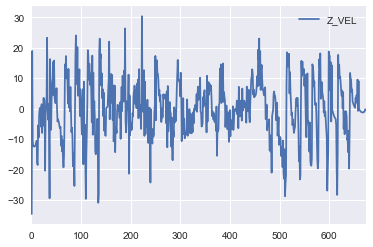

In [42]:
test['Z_VEL'] = test['BALL_ZLOC'].diff() / .04
test['Z_ACC'] = test['Z_VEL'].diff() / .04
test.loc[test['EVENT_NUM'] == 9, ['Z_VEL']].plot()

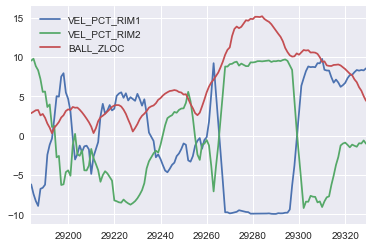

In [64]:
events = list(test.loc[test['SHOT_DISTANCE'].between(10, 30), 'EVENT_NUM'].unique())
test.loc[(test['EVENT_NUM'] == events[30]) &
         (test['SHOT_TIME'] - 1 < test['GAME_CLOCK']) &
         (test['SHOT_TIME'] + 5 > test['GAME_CLOCK']), 
                                          ['VEL_PCT_RIM1',
                                           'VEL_PCT_RIM2',
                                           #'BALL_VELRELRIM1',
                                           #'BALL_DIST_RIM1',
                                           'BALL_ZLOC']].plot()